# Rubin LSST DESC DC2: Accessing Object Table with GCRCatalogs

**Authors**: Yao-Yuan Mao (@yymao), Francois Lanusse (@EiffL), Javier Sanchez (@fjaviersanchez), Michael Wood-Vasey (@wmwv), Rachel Mandelbaum (@rmandelb)

This notebook will illustrate the basics of accessing the Object Table, which contains the detected objects at the coadd level using GCRCatalogs.

**Learning objectives**: After going through this notebook, you should be able to:
  1. Load and efficiently access a DC2 object table with the GCRCatalogs
  2. Understand and have references for the object table schema
  3. Apply cuts to the catalog using GCRQuery
  4. Have an example of quality cuts and simple star/galaxy separation cut

## Before you start

Make sure you have followed the instructions on the [DESC Data Portal](https://lsstdesc-portal.nersc.gov/) to 
download the data files, install `GCRCatalogs`, and set up `root_dir` for `GCRCatalogs`.

In this example notebook we will use up to 4 tracts: 3830, 3831, 4028, 4029. 
The example set from the Data Portal includes these four tracts, so If you have downloaded it you are all set. 
If you have downloaded different tracts, remember to change the tract number(s) used in `tract_filter` when you run this notebook.

## Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCRCatalogs import GCRQuery

## Access object table with GCRCatalogs

The [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs) package is a DESC project which aims at gathering in one convenient location various simulation/data catalogs made available to the collaboration. In this section, we illustrate how to use this tool to access the object catalogs from DC2 Run2.2i.

In [3]:
GCRCatalogs.get_public_catalog_names()

['desc_cosmodc2',
 'desc_dc2_run2.2i_dr6_object',
 'desc_dc2_run2.2i_dr6_object_with_truth_match',
 'desc_dc2_run2.2i_dr6_truth']

In [4]:
obj_cat = GCRCatalogs.load_catalog("dc2_object_run2.2i_dr6_v1")

### Object Table schema

To see the "columns" (sometimes called "quantities") available in the object table, you can call `list_all_quantities()`.
The returned list of `list_all_quantities` is not sorted. Sorting it would make it easier to read.

In [5]:
sorted(obj_cat.list_all_quantities())

['I_flag',
 'I_flag_g',
 'I_flag_i',
 'I_flag_r',
 'I_flag_u',
 'I_flag_y',
 'I_flag_z',
 'IxxPSF_pixel',
 'IxxPSF_pixel_g',
 'IxxPSF_pixel_i',
 'IxxPSF_pixel_r',
 'IxxPSF_pixel_u',
 'IxxPSF_pixel_y',
 'IxxPSF_pixel_z',
 'Ixx_pixel',
 'Ixx_pixel_g',
 'Ixx_pixel_i',
 'Ixx_pixel_r',
 'Ixx_pixel_u',
 'Ixx_pixel_y',
 'Ixx_pixel_z',
 'IxyPSF_pixel',
 'IxyPSF_pixel_g',
 'IxyPSF_pixel_i',
 'IxyPSF_pixel_r',
 'IxyPSF_pixel_u',
 'IxyPSF_pixel_y',
 'IxyPSF_pixel_z',
 'Ixy_pixel',
 'Ixy_pixel_g',
 'Ixy_pixel_i',
 'Ixy_pixel_r',
 'Ixy_pixel_u',
 'Ixy_pixel_y',
 'Ixy_pixel_z',
 'IyyPSF_pixel',
 'IyyPSF_pixel_g',
 'IyyPSF_pixel_i',
 'IyyPSF_pixel_r',
 'IyyPSF_pixel_u',
 'IyyPSF_pixel_y',
 'IyyPSF_pixel_z',
 'Iyy_pixel',
 'Iyy_pixel_g',
 'Iyy_pixel_i',
 'Iyy_pixel_r',
 'Iyy_pixel_u',
 'Iyy_pixel_y',
 'Iyy_pixel_z',
 'blendedness',
 'cModelFluxErr_g',
 'cModelFluxErr_i',
 'cModelFluxErr_r',
 'cModelFluxErr_u',
 'cModelFluxErr_y',
 'cModelFluxErr_z',
 'cModelFlux_flag_g',
 'cModelFlux_flag_i',
 'cModel

The definitions, units, and types of these fields are documented in the data release note (Table 1).
As explained in the note, the values exposed here are not the native columns produced by the LSST Science Pipelines.
Instead, this schema strives to mimic the schema of the LSST Data Products Definition Document [DPDD](http://ls.st/dpdd), 
which is an effort made by the Rubin Observatory to standardize the format of the official Data Release Products (DRP).

If the data release note is many clicks away, you can also check the definitions, units, and types of these columns
using `get_quantity_info()`. Here's an example:

In [6]:
obj_cat.get_quantity_info("Iyy_pixel_r")

{'type': 'float64',
 'unit': 'sq. pixel',
 'description': 'Adaptive second moment (yy) of source intensity in r'}

We can see that the catalog includes:
* Positions
* Fluxes and magnitudes (PSF and [CModel](https://www.sdss.org/dr12/algorithms/magnitudes/#cmodel))
* Adaptive second moments (using [GalSim's HSM](http://galsim-developers.github.io/GalSim/namespacegalsim_1_1hsm.html))
* Quality flags: e.g, does the source have any interpolated pixels? Has any measurement algorithm returned an error?
* Other useful quantities: `blendedness`, measure of how flux is affected by neighbors: (1 - flux.child/flux.parent) (see section 4.9.11 of [Bosch et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B)); `extendedness`, classifies sources as extended or point source (see section 4.9.10 of [Bosch et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B)).

### Accessing data in an interactive session

The DC2 DR6 is a very large data set; loading the full object table into memory is usually not feasible. To access the data in a memory efficient fashion while maintaining reasonable performace, we usually need to do one or a combination of the following measures. 

1. Loading only the columns that you immediately need
2. Loading a subset of the sky area that you immediately need, or iterating over sky areas ("tracts"; see below)
3. Sampling the table at random if your science allows

Because the physical data files are in Parquet format, loading specific columns (1) is efficient and does not require reading in the full table. 
The physical data files are also partitioned in "tracts", each of which corresponds to a region of the sky (see Figure 1 of the release note); hence, loading only a subset of "tracts" or iterating over tracts (2) will also make the memory footprint much smaller. 
Finally, subsampling the table at random can make your analysis faster and use less memory, but it does not save much in term of I/O as all the rows need to be read in before subsampling.


#### If you use GCRCatalogs to access the data

You will use `get_quantities` to retrieve the data, and there are several convenient, high-level features that help you achieve the three measures described above. When calling `get_quantities`, you can

1. Specify the columns to load
2. Add `tract_filter(tracts)` to `native_filters` to select tracts, and use `return_iterator` to iterate over tracts
3. Add `sample_filter(frac)` to `filters` to sample the data frame at random

Here `tract_filter` and `sample_filter` are helper functions that can be imported from `GCRCatalogs.helpers.tract_catalogs`.
We will demostrate all these features in this notebook.


#### If you use pandas to read the data files directly

You can achieve the three measures described above by:

1. Specifying the `columns` argument when calling `pandas.read_parquet`
2. Reading in one file (i.e., one tract) at a time, and only reading in the tracts you need
3. Using `pandas.DataFrame.sample` to sample the data frame at random

### Using GCRCatalogs' `get_quantities`

#### Call signature

```python
obj_cat.get_quantities(quantities=[...], filters=[...], native_filters=[...], return_iterator=True/False)
```

You can supply:
* a list of column names of those you want to load to `quantities`. 
* a list of `GCRQuery`s (including `sample_filter`'s return and other quality cuts (see later part of this notebook)) to `filters`
* a list of tract-selecting `GCRQuery`s (i.e., those returned by  `tract_filter`) to `native_filters`
* `True` to `return_iterator` if you want to iterate over tracts, or `False` (default) if you want to concatenate data across tracts. 

`get_quantities` will return (or yield, if `return_iterator=True`) a Python dictionary that contains
columns names as keys and corresponding column arrays as values. 

We will learn more about `GCRQuery` and `return_iterator` latter. For now, let's first learn how to use the two helper functions that we imported earlier: `tract_filter` and `sample_filter`. 

#### Using `tract_filter`

There are three ways to call `tract_filter`

```python
tract_filter(3830)  # select one tract, 3830
tract_filter(4200, 4300)  # select all tracts between 4200 and 4300 (inclusive on both ends!)
tract_filter([3830, 3831, 4028, 4029])  # select the tracts specified in the list
```

You can then directly use the returns in the `native_filters` argument of `get_quantities`. Note that these tract filters will select on matched tracts, but will *not* warn or raise errors if a wanted tract is not available. 

`obj_cat.available_tracts` will give you a list of tracts that are available (i.e., the ones you have downloaded). If you defined a tract filter, you can also preview the list of tracts that satisfy the filter. See the example below.

In [7]:
len(obj_cat.available_tracts)

166

In [8]:
tract_filter(3000, 4000).filter({"tract": np.array(obj_cat.available_tracts)})

{'tract': array([3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084,
        3085, 3086, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264,
        3265, 3266, 3267, 3268, 3441, 3442, 3443, 3444, 3445, 3446, 3447,
        3448, 3449, 3450, 3451, 3452, 3453, 3454, 3631, 3632, 3633, 3634,
        3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3825, 3826,
        3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837])}

#### Using `sample_filter`

There are two ways to call `sample_filter`

```python
sample_filter(0.2)  # select 20% of entries at random
sample_filter(0.01, random_state=1234)  # select 1% of entries at random, but using a fixed random seed 1234
```

You can then directly use the returns in the `filters` argument  of `get_quantities`.

Now let's look at an example! We would like to retrieve the coordinates (ra, dec) of all objects in 4 tracts: 3830, 3831, 4028, 4029, and apply a down-sampling fraction of 1%. 

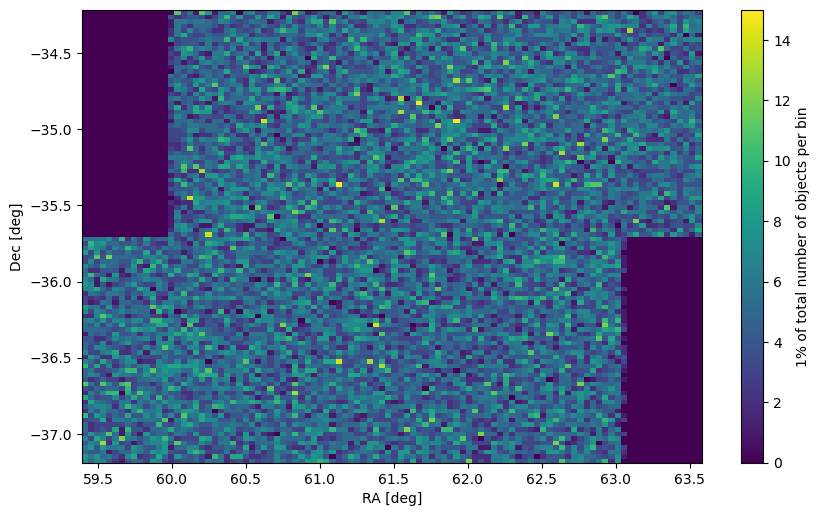

In [9]:
data = obj_cat.get_quantities(
    quantities=['ra', 'dec'],                                # columns we want to load, 
    filters=[sample_filter(0.01)],                           # down sample at 1%
    native_filters=[tract_filter([3830, 3831, 4028, 4029])], # select four tracts
    return_iterator=False,                                   # concatenate data across tracts 
)

# Plot a 2d histogram of sources 
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
im = ax.hist2d(data['ra'], data['dec'], 100)[-1]
ax.set_xlabel('RA [deg]');
ax.set_ylabel('Dec [deg]');
plt.colorbar(im, ax=ax, label='1% of total number of objects per bin');

#### Returned data of `get_quantities`

As mentioned above, the data returned by the GCR is structured as a native Python dictionary:

In [ ]:
data

But it can also easily be converted into a [Pandas DataFrame](https://pandas.pydata.org), if you are so inclined ;-)

In [ ]:
import pandas as pd

df = pd.DataFrame(data)
df

Or an [astropy table](https://docs.astropy.org/en/stable/table/) too!

In [ ]:
import astropy.table

table = astropy.table.Table(data)
table

#### Using `return_iterator` when calling `get_quantities`

Concatenating data across tracts is convenient but costs more memory. If your analysis allows, a more memory efficient approach would be to reduce the data for one tract, stored the reduced product, and repeat for other tracts. The `return_iterator` option will turn `get_quantities` into a generator function (i.e., can used in a for loop directly, like `range`), making it easy for users to iterate over tracts.

In the example below, we will loop over the four example tracts (you can look up tract numbers in Figure 1 of the release note).
For each tract, we will load 0.1% of the objects and put them on a scatter plot. We will also print out a message to see where we are in the for loop. When the loop finishes, we should see a beautiful and colorful map, as each tract will be plotted in a different color!

In [ ]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

for data in obj_cat.get_quantities(                           # note how we use `get_quantities` directly in a for loop
    quantities=['ra', 'dec', 'tract'],                        # columns we want to load, 
    filters=[sample_filter(0.001)],                           # down sample at 0.1%
    native_filters=[tract_filter([3830, 3831, 4028, 4029])],  # select 4 tracts
    return_iterator=True,                                     # return an iterator that iterates over tracts
):
    print("Plotting data from tract", data["tract"][0])  # print out which tract is current being plotted
    ax.scatter(data['ra'], data['dec'], s=1, label=str(data["tract"][0]));
    # You can put more science here! 

ax.set_xlabel('RA [deg]');
ax.set_ylabel('Dec [deg]');
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Tract", handletextpad=0);

#### Applying more filters (quality cuts or selection cuts)

So far we have only used the sampler in the `filters` option of `get_quantities`. 
In a more realistic setting, you likely would want to apply certain quality cuts or selection cuts to your data. 
You can of course apply these cuts _after_ you read in the data, especially if you want to play with different cut choices. 
On the other hand, if you already know certain quality cuts or selection cuts that you always want to apply, 
then applying them at data load time (i.e., when calling `get_quantities`) can save some memory for you! 

*Note*: If you want to apply cuts after reading in the data, it would be easier to first convert the returned data 
(which is a python dictionary) into a pandas data frame or an astropy table (see instructions in the earlier part of this notebook), 
and then apply the cuts. This way, all columns will be filtered with the same cuts at once. 

To apply cuts at data load time, you first need to specify your quality cuts or selection cuts using `GCRQuery`, 
and then add them to the `filters` option of `get_quantities`.
You can read more about how to specify the queries [here](https://github.com/yymao/easyquery#usage), 
but we will show you some common examples below.

Each query should be a string that contains a *simple* python expression (see [numexpr doc](https://numexpr.readthedocs.io/en/latest/user_guide.html#supported-operators) for supported operators and functions), in which the variables are column names. 
The expression should evaluate to a boolean array. 

Alternatively, a query can also be in the form of `GCRQuery((func, col1, col2, ...))` (note the two pairs of parentheses).
In this form, `col1`, `col2`, ... should be column names, and `func(d[col1], d[col2], ...)` should return a boolean array
that has the same length.

In [ ]:
# Some basic query constructions

GCRQuery('clean')  # selects `clean` == True  -- note that clean is a boolean array itself
GCRQuery('extendedness == 0')  # selects `extendedness` == 0
GCRQuery((np.isfinite, 'mag_r_cModel'))  # selects `mag_r_cModel` is finite
GCRQuery((np.isfinite, 'mag_r_cModel'), "mag_r_cModel < 25")  # selects `mag_r_cModel` is finite *AND* mag_r_cModel < 25
GCRQuery("mag_g_cModel - mag_r_cModel < 1")  # selects `mag_g_cModel` - `mag_r_cModel` < 1


# You can name the queries, and do logical operations (AND &, OR |, XOR ^, NOT ~) on them

is_extended = GCRQuery('extendedness == 1')
clean = GCRQuery('clean')
not_clean = ~clean
finite_g = GCRQuery((np.isfinite, 'mag_g_cModel'))
finite_r = GCRQuery((np.isfinite, 'mag_r_cModel'))
bright_g = finite_g & GCRQuery("mag_g_cModel < 25")
bright_r = finite_r & GCRQuery("mag_r_cModel < 25")
bright_g_or_r = bright_g | bright_r

Once you defined these queries, you can just put them in a list that you supply to the `filters` option of `get_quantities`. 

All queries in a lists will be joined by *AND*. If `a`, `b`, and `c` are all `GCRQuery` objects, then:

- `filters=[a, b, c]` is the same as `filters=[a & b & c]`
- `filters=[a, b | c]` means selecting on `a` AND (`b` OR `c`)


Specifying `filters` when calling `get_quantities` is similar to slicing the data based on the `GCRQuery` that you supply. 
For example, the following three methods will all produce the same data frames:

```python
# method1
df = pd.DataFrame(obj_cat.get_quantities(["ra", "dec"], filters=[GCRQuery("mag_g_cModel - mag_r_cModel < 1")]))

# method2
df = pd.DataFrame(obj_cat.get_quantities(["ra", "dec", "mag_g_cModel", "mag_r_cModel"]))
df = df.query("mag_g_cModel - mag_r_cModel < 1")
df = df["ra", "dec"]

# method3
df = pd.DataFrame(obj_cat.get_quantities(["ra", "dec", "mag_g_cModel", "mag_r_cModel"]))
df = df[df["mag_g_cModel"] - df["mag_r_cModel"] < 1]
df = df["ra", "dec"]
```

Note that when using `filters`, you don't need to add quantities that are only used in the filter queries to the `quantities` argument. 
However if you want to keep those quantities, remember to add them to `quantities` too. 
For those who are familiar with SQL, the behavior here is analogous to `SELECT <quantities> WHERE <filters>`.

In [ ]:
# prepare to store the reduced histogram during the iteration 
color_bins = np.linspace(-2, 3, 101)
hist = np.zeros(len(color_bins)-1, dtype=np.int)

# iterate over tract using get_quantities(..., return_iterator=True)
for data in obj_cat.get_quantities(
    quantities=['mag_g_cModel', 'mag_r_cModel'],                            # columns we want to load, 
    filters=[sample_filter(0.1), clean, is_extended, bright_g | bright_r],  # filters we want, including the sampler
    native_filters=[tract_filter([3830, 3831, 4028, 4029])],                # select four tracts
    return_iterator=True,                                                   # return an iterator
):
    gr = data["mag_g_cModel"] - data["mag_r_cModel"]
    hist += np.histogram(gr, color_bins)[0]  # accumulate the histogram

# Plot a 1d histogram of colors 
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
ax.bar(color_bins[:-1], hist, width=np.ediff1d(color_bins))
ax.set_xlabel("Galaxy color $g-r$ [mag]");
ax.set_ylabel("10% of counts per bin");

## Science examples

Finally, we will show some science examples that combine what we have learned so far. 
These examples can be used as your own analyses!

### Galaxy number density

We have `extendedness` as a tool for star/galaxy classification. An object is considered extended if the difference between the `PSF` magnitude and the [`CModel` magnitude](https://www.sdss.org/dr12/algorithms/magnitudes/#cmodel) is above a certain threshold (0.0164). To learn more about this see [Bosch et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B) section 4.9.10.

Let's first define a few useful cuts.

In [ ]:
is_extended = GCRQuery('extendedness == 1')  # Extended objects (primarily galaxies)
clean = GCRQuery('clean')  # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                           # and was not skipped by the deblender

galaxy_cuts = [
    clean,
    is_extended, 
    GCRQuery((np.isfinite, 'mag_i_cModel')),  # Select objects that have i-band cmodel magnitudes
]

Now we will load the data from just one tract to save run time. 
To make a galaxy number density plot (as a function of magnitude), we need the galaxy magnitude, and RA/Dec to calculate the sky area.

In [ ]:
# columns we need -- note that you don't need to include the columns used in your cuts if you don't need them
# for purposes other than the cuts!
columns = ["ra", "dec", "mag_i_cModel"]

data = obj_cat.get_quantities(
    quantities=columns, 
    filters=galaxy_cuts, 
    native_filters=[tract_filter(3830)]
)

As we see earlier, the geometry of a tract is rectangular, so here we are going to use naive area estimates.

In [ ]:
d_ra = data["ra"].max() - data["ra"].min()
d_dec = data["dec"].max() - data["dec"].min()
cos_dec = np.cos(np.deg2rad(np.median(data["dec"])))
sky_area_sq_arcmin = (d_ra * cos_dec * 60) * (d_dec * 60)
print(sky_area_sq_arcmin)

In [ ]:
mag_bins = np.linspace(20, 30, 51)

cdf = np.searchsorted(data["mag_i_cModel"], mag_bins, sorter=data["mag_i_cModel"].argsort())

plt.semilogy(mag_bins, cdf / sky_area_sq_arcmin)
plt.xlabel("$i$-band cModel mag");
plt.ylabel("Cumulative number per sq. arcmin");

plt.grid();  # add grid to guide our eyes

### Stellar locus

Let's now take a look at the colors of objects that we think are stars. We will do this on only one tract to save run time.

In [ ]:
star_cuts = [
    clean,
    ~is_extended,
    GCRQuery((np.isfinite, 'mag_g')), # Have finite point-source model magnitudes 
    GCRQuery((np.isfinite, 'mag_r')),
    GCRQuery((np.isfinite, 'mag_i')),
]

# columns we need -- note that you don't need to include the columns used in your cuts if you don't need them
# for purposes other than the cuts!
columns = ['mag_g', 'mag_r', 'mag_i']

# loading the data
data = obj_cat.get_quantities(
    quantities=columns, 
    filters=star_cuts, 
    native_filters=[tract_filter(3830)]
)

fig, ax = plt.subplots(figsize=(7,6), dpi=100)
im = ax.hexbin(
    data['mag_g']-data['mag_r'],
    data['mag_r']-data['mag_i'],
    bins='log', 
    extent=[-1,2,-1,2],
)
ax.set_xlabel('$g-r$ [mag]');
ax.set_ylabel('$r-i$ [mag]');
plt.colorbar(im, ax=ax, label='log(Number of objects)');